### Khang Tran Homework 03 Classification

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'
df = pd.read_csv(url)
df

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
...,...,...,...,...,...,...,...,...,...
1457,referral,manufacturing,1,NaN,self_employed,north_america,4,0.53,1
1458,referral,technology,3,65259.0,student,europe,2,0.24,1
1459,paid_ads,technology,1,45688.0,student,north_america,3,0.02,1
1460,referral,NaN,5,71016.0,self_employed,north_america,0,0.25,1


In [21]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [22]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [23]:
df[['lead_source','industry','employment_status','location']] = df[['lead_source','industry','employment_status','location']].fillna('NA')
df['annual_income'] = df['annual_income'].fillna(0)

### Q1. the most frequent observation (mode) for the column `industry`?

In [24]:
df['industry'].describe()

count       1462
unique         8
top       retail
freq         203
Name: industry, dtype: object

In [30]:
[i for i in df.columns if df[i].dtype != 'object' and i != 'converted']

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score']

### Q2. Correlation matrix:

<Axes: >

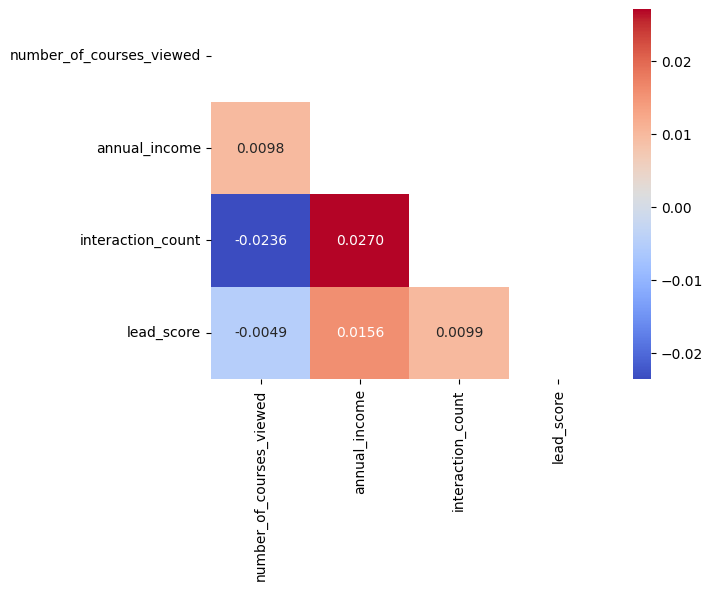

In [29]:
numerical_features = [i for i in df.columns if df[i].dtype != 'object' and i != 'converted']
sns.heatmap(df[numerical_features].corr(), annot=True, fmt=".4f", mask = np.triu(df[numerical_features].corr()), cmap="coolwarm")

In [32]:
## Split the data
from sklearn.model_selection import train_test_split

## Seperate features and target
X = df.drop('converted', axis=1)
y = df['converted']

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=1)

### Q3. Mutual Information between y and other categorical features

<Axes: >

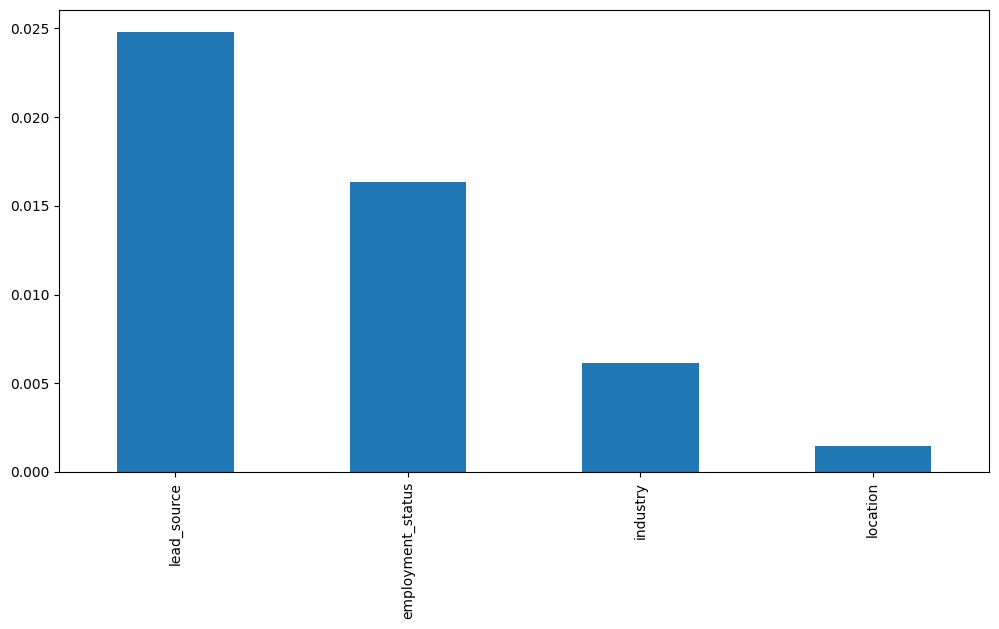

In [34]:
mutual_info = {}
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

mutual_info = {}

for col in X_train.columns:
    if X_train[col].dtype == 'object':
        # Encode text categories to numeric labels
        le = LabelEncoder()
        X_encoded = le.fit_transform(X_train[col].astype(str))  # convert to string in case of NaN
        mutual_info[col] = mutual_info_classif(
            X_encoded.reshape(-1, 1), y_train, discrete_features=True
        )[0]

mutual_info = pd.Series(mutual_info)
mutual_info.sort_values(ascending=False).plot.bar(figsize=(12,6))


### Q4. Base Logistic Regression:

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

categorical = [col for col in X_train.columns if X_train[col].dtype == 'object']
lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = ohe.fit_transform(X_train[categorical])
X_val_cat = ohe.transform(X_val[categorical])
X_test_cat = ohe.transform(X_test[categorical])

lr.fit(X_train_cat, y_train)
y_val_pred = lr.predict(X_val_cat)
accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {accuracy:.2f}')

Validation Accuracy: 0.62


### Q5. the least useful feature using the *feature elimination* technique:

### Q6. Regularized Logistic Regression:

In [41]:
C_list = [0.01, 0.1, 1, 10, 100]
for C in C_list:
    lr = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
    lr.fit(X_train_cat, y_train)
    y_val_pred = lr.predict(X_val_cat)
    accuracy = accuracy_score(y_val, y_val_pred)
    print(f'C={C}: Validation Accuracy: {accuracy:.3f}')


C=0.01: Validation Accuracy: 0.614
C=0.1: Validation Accuracy: 0.628
C=1: Validation Accuracy: 0.618
C=10: Validation Accuracy: 0.621
C=100: Validation Accuracy: 0.621
